<a href="https://colab.research.google.com/github/nikogarro/Deep-Learning/blob/main/Malaria_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split =['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete1XQ4XF/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmp7kooqbn3tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [5]:
def split(dataset, Train_Ratio, Val_Ratio, Test_Ratio):
    Dataset_size = len(dataset)

    train_dataset = dataset.take(int(Train_Ratio*Dataset_size))

    val_test_dataset = dataset.skip(int(Train_Ratio*Dataset_size))
    val_dataset = val_test_dataset.take(int(Val_Ratio*Dataset_size))

    test_dataset = val_test_dataset.skip(int(Val_Ratio*Dataset_size))

    return train_dataset, val_dataset, test_dataset

In [38]:
Train_Ratio = 0.8
Val_Ratio = 0.2
Test_Ratio = 0.2

In [62]:
train_dataset, val_dataset, test_dataset = split(dataset[0], Train_Ratio, Val_Ratio, Test_Ratio)

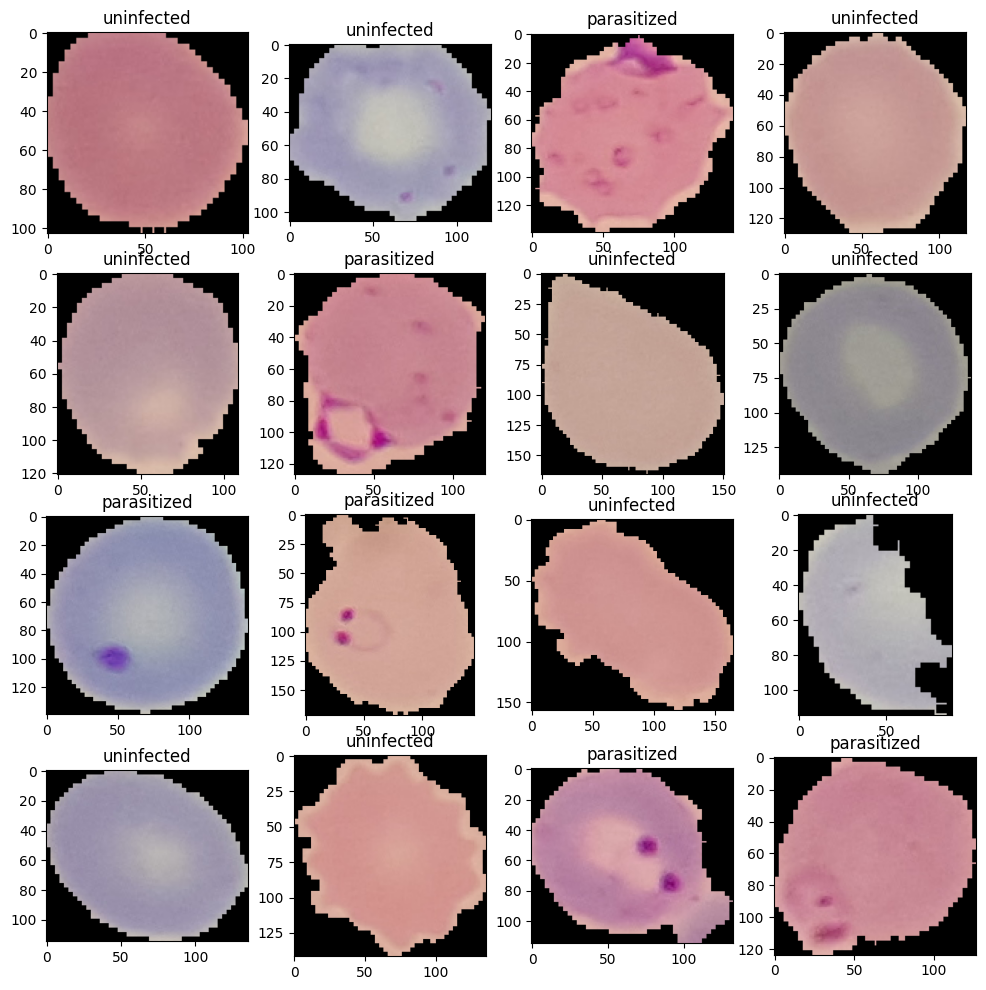

In [8]:
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))

In [60]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [63]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [11]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [12]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),
    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid'),

])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [18]:
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [19]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 20, verbose=1)

Epoch 1/20
776/776 [==============================] - 73s 74ms/step - loss: 0.4671 - accuracy: 0.7771 - val_loss: 0.4908 - val_accuracy: 0.7776
Epoch 2/20
776/776 [==============================] - 49s 64ms/step - loss: 0.2467 - accuracy: 0.9064 - val_loss: 0.2210 - val_accuracy: 0.9213
Epoch 3/20
776/776 [==============================] - 59s 76ms/step - loss: 0.2005 - accuracy: 0.9272 - val_loss: 0.2433 - val_accuracy: 0.9224
Epoch 4/20
776/776 [==============================] - 47s 60ms/step - loss: 0.1739 - accuracy: 0.9375 - val_loss: 0.1821 - val_accuracy: 0.9347
Epoch 5/20
776/776 [==============================] - 60s 77ms/step - loss: 0.1526 - accuracy: 0.9452 - val_loss: 0.2596 - val_accuracy: 0.9104
Epoch 6/20
776/776 [==============================] - 56s 71ms/step - loss: 0.1252 - accuracy: 0.9543 - val_loss: 0.1866 - val_accuracy: 0.9390
Epoch 7/20
776/776 [==============================] - 59s 77ms/step - loss: 0.1013 - accuracy: 0.9623 - val_loss: 0.2438 - val_accuracy:

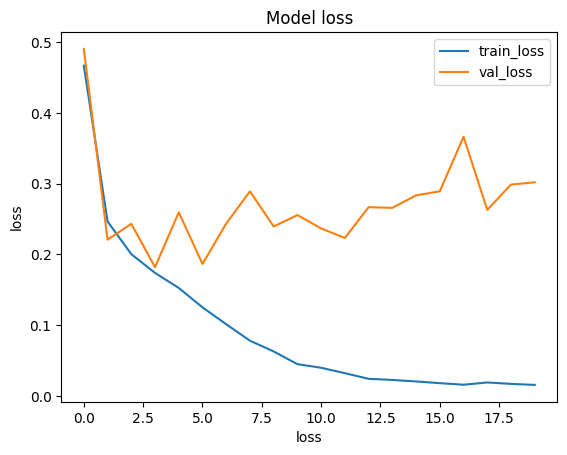

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

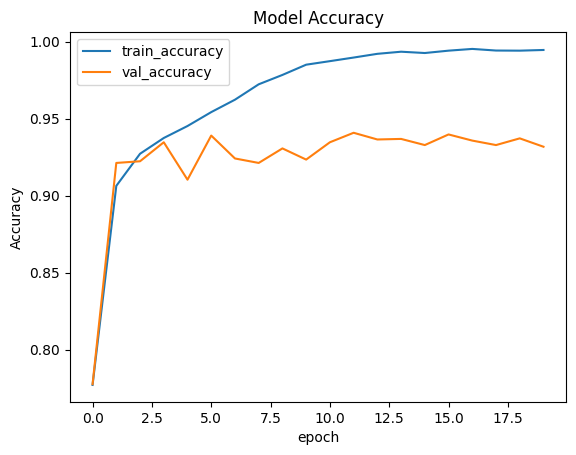

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [84]:
test_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [83]:
test_dataset = test_dataset.batch(1)
model.evaluate(test_dataset)

1/1 [==============================] - 11s 11s/step - loss: 0.0140 - accuracy: 1.0000


[0.013999643735587597, 1.0]

In [75]:
def parasite_or_not(x):
    if(x<0.5): return str('Parasite')
    else: return str('Uninfected')

parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 13s 13s/step


'Parasite'

1/1 [==============================] - 0s 18ms/step


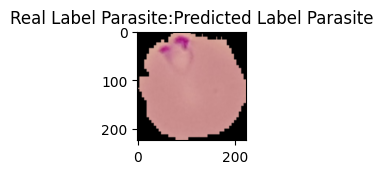

In [86]:

for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title("Real Label " + str(parasite_or_not(label.numpy()[0])) + ':' + "Predicted Label " + str(parasite_or_not(model.predict(image)[0][0])))